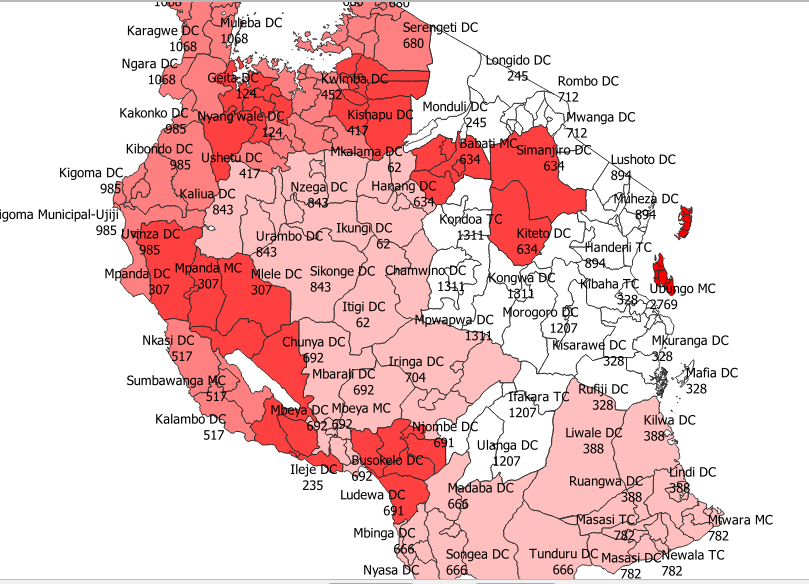

In [21]:
from IPython.display import Image,display
path = "C:/Users/LYNIX/Desktop/crime rate.png"
display(Image(filename=path, width=1000))


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from geopy.distance import great_circle
from shapely.geometry import MultiPoint


In [37]:

# Load the data
df = pd.read_csv('techgems.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nData types and missing values:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (490, 12)

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Crime ID               431 non-null    object 
 1   Month                  490 non-null    object 
 2   Reported by            490 non-null    object 
 3   Falls within           490 non-null    object 
 4   Longitude              477 non-null    float64
 5   Latitude               477 non-null    float64
 6   Location               490 non-null    object 
 7   LSOA code              477 non-null    object 
 8   LSOA name              477 non-null    object 
 9   Crime type             490 non-null    object 
 10  Last outcome category  431 non-null    object 
 11  Context                0 non-null      float64
dtypes: float64(3), object(9)
memory usage: 46.1+ KB
None

First few rows:
                                   

In [55]:
df.head()


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
0,034e029aeb263e7da933e57d5fc3ae3178285faf8630fc...,2015-10,City of London Police,City of London Police,-0.113767,51.517372,On or near Stone Buildings,E01000914,Camden 028B,Theft from the person,Investigation complete; no suspect identified
1,670903e6bbaba82c9ff72f73eaf419934c013b201bb488...,2015-10,City of London Police,City of London Police,0.554409,51.511394,On or near Haven Quays,E01021501,Castle Point 011D,Other theft,Investigation complete; no suspect identified
2,NaN,2015-10,City of London Police,City of London Police,-0.097601,51.520699,On or near Carthusian Street,E01000001,City of London 001A,Anti-social behaviour,NaN
3,NaN,2015-10,City of London Police,City of London Police,-0.095914,51.520348,On or near Beech Street,E01000001,City of London 001A,Anti-social behaviour,NaN
4,9874882d3cdb48618c5d1d422ce2684f214e14e2d811ef...,2015-10,City of London Police,City of London Police,-0.097562,51.518864,On or near Parking Area,E01000001,City of London 001A,Bicycle theft,Investigation complete; no suspect identified


In [64]:
# Handle missing values
missing_count = df['Crime ID'].isna().sum()

# Generate new IDs only for missing values
if missing_count > 0:
    # Create new IDs for missing values
    new_ids = ['GEN_' + str(i) for i in range(1, missing_count + 1)]
    # Assign them to the missing positions
    df.loc[df['Crime ID'].isna(), 'Crime ID'] = new_ids

# For location data, drop rows with missing coordinates
df = df.dropna(subset=['Longitude', 'Latitude'])

# For other categorical columns, fill with 'Unknown'
df['Last outcome category'] = df['Last outcome category'].fillna('Unknown')

# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Verify no missing values remain
print(f"\nCleaned dataset shape: {df.shape}")
print("\nMissing values after cleaning:")
print(df.isna().sum())


Cleaned dataset shape: (477, 11)

Missing values after cleaning:
Crime ID                 0
Month                    0
Reported by              0
Falls within             0
Longitude                0
Latitude                 0
Location                 0
LSOA code                0
LSOA name                0
Crime type               0
Last outcome category    0
dtype: int64


FEATURE ENGINEERING

In [67]:
# Extract time-based features
df['Year'] = df['Month'].dt.year
df['Month_num'] = df['Month'].dt.month
df['Day'] = df['Month'].dt.day

# Create binary target for high-risk areas (we'll define this based on crime density)
# First, let's calculate crime density by location

# Function to get the nearest neighborhood points
def get_nearest_neighbors(df, radius=0.01):
    coords = df[['Latitude', 'Longitude']].values
    kms_per_radian = 6371.0088
    epsilon = radius / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    return db.labels_

# Assign cluster labels
df['location_cluster'] = get_nearest_neighbors(df)

# Calculate crime density per cluster
cluster_counts = df['location_cluster'].value_counts()
df['crime_density'] = df['location_cluster'].map(cluster_counts)

# Define high-risk areas (top 20% of crime density)
risk_threshold = df['crime_density'].quantile(0.8)
df['high_risk'] = (df['crime_density'] >= risk_threshold).astype(int)

# Check the distribution
print("\nHigh risk vs Low risk distribution:")
print(df['high_risk'].value_counts(normalize=True))


High risk vs Low risk distribution:
high_risk
0    0.796646
1    0.203354
Name: proportion, dtype: float64


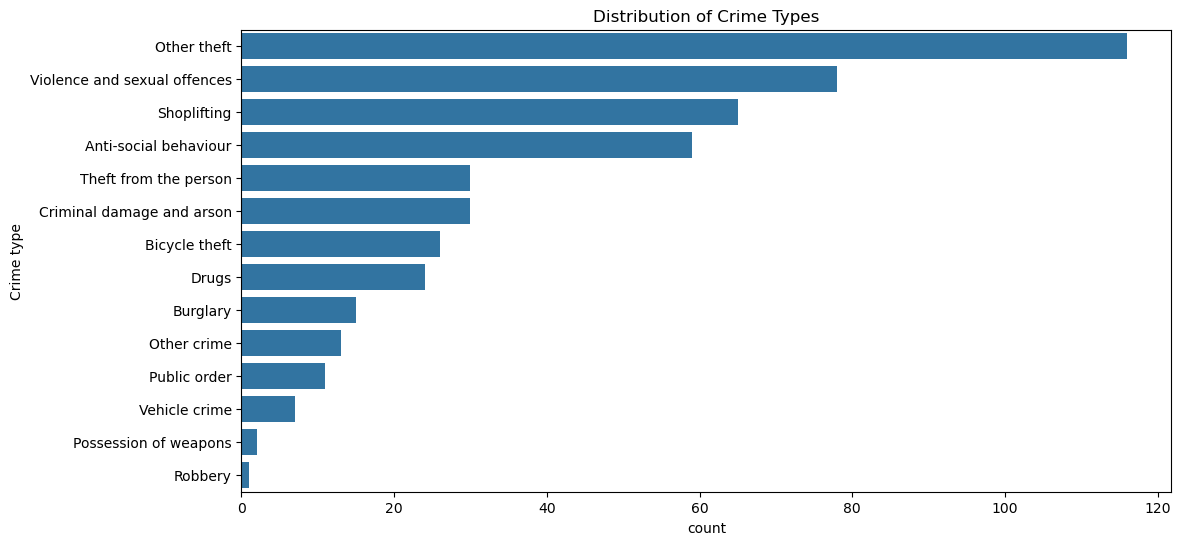

In [69]:
# Crime type distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Crime type', data=df, order=df['Crime type'].value_counts().index)
plt.title('Distribution of Crime Types')
plt.show()


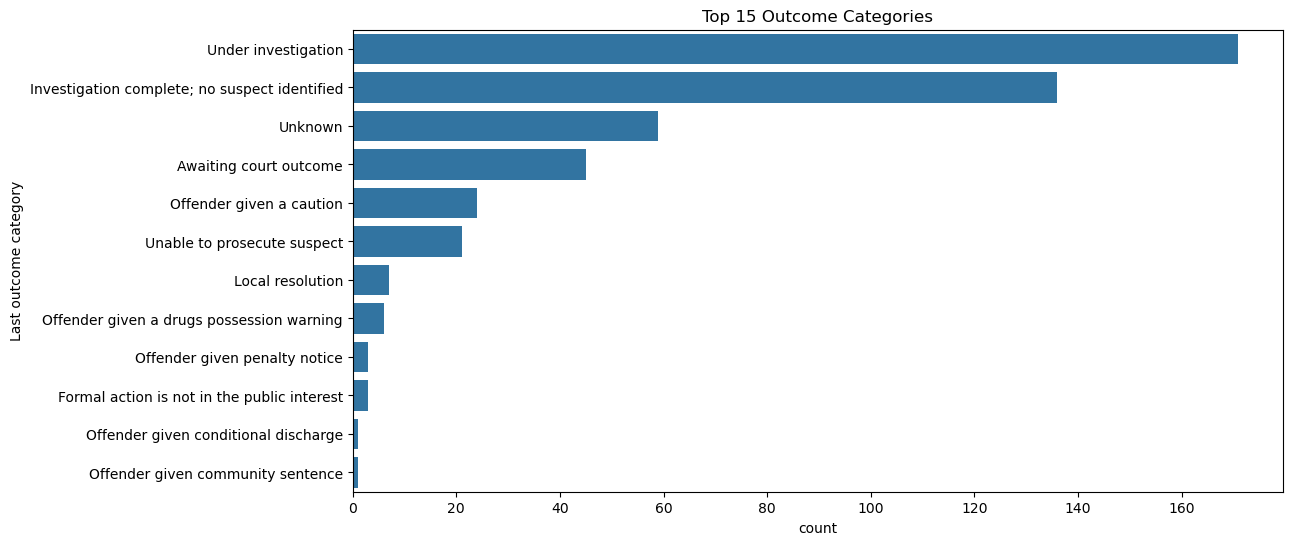

In [71]:
# Outcome category distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Last outcome category', data=df, 
              order=df['Last outcome category'].value_counts().iloc[:15].index)
plt.title('Top 15 Outcome Categories')
plt.show()

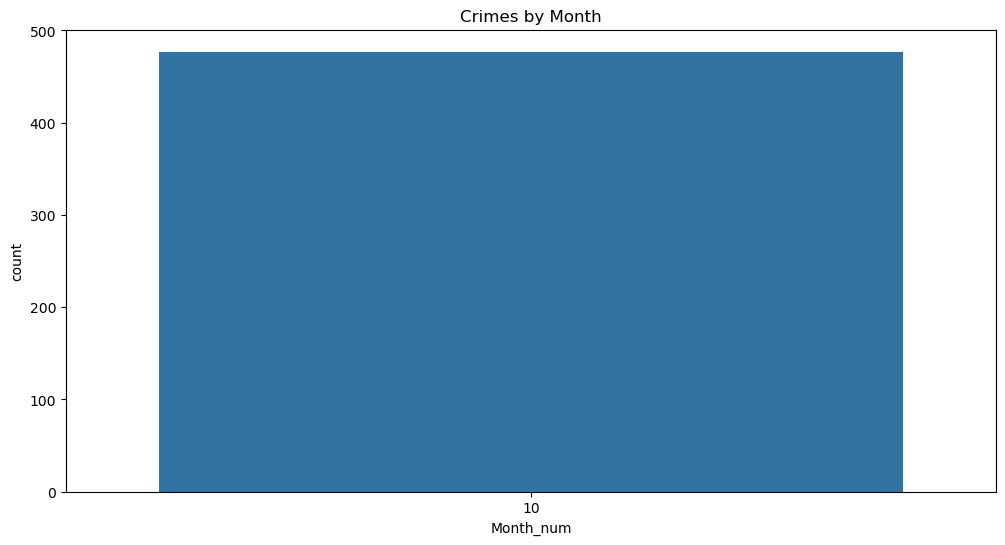

In [73]:
# Temporal patterns
plt.figure(figsize=(12, 6))
sns.countplot(x='Month_num', data=df)
plt.title('Crimes by Month')
plt.show()

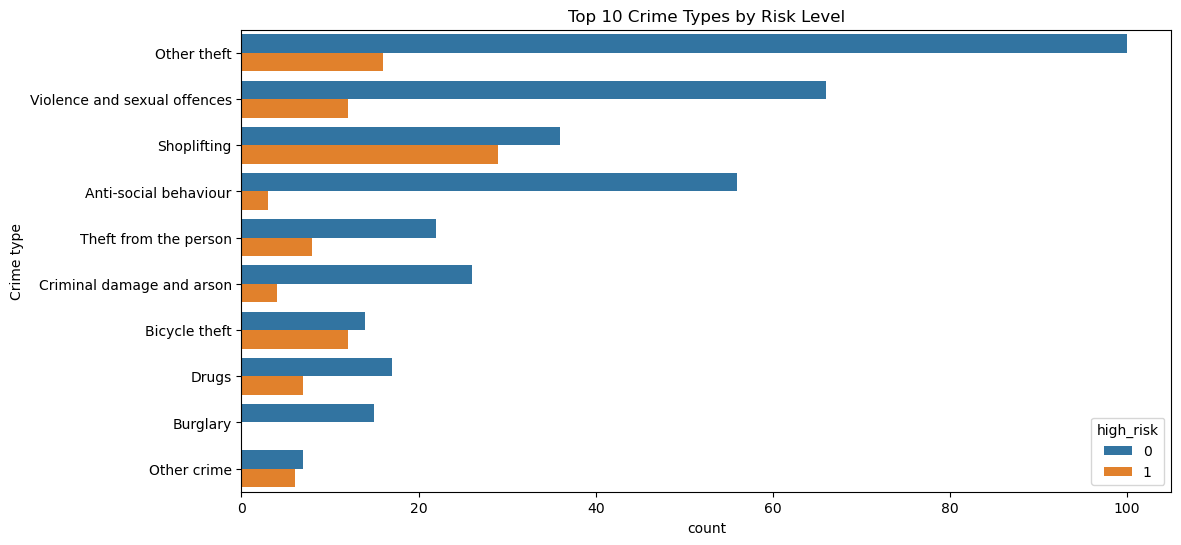

In [75]:
# High-risk vs low-risk by crime type
plt.figure(figsize=(12, 6))
sns.countplot(y='Crime type', hue='high_risk', data=df,
              order=df['Crime type'].value_counts().iloc[:10].index)
plt.title('Top 10 Crime Types by Risk Level')
plt.show()

MACHINE LEARNING

In [80]:
# Prepare features for modeling
features = pd.get_dummies(df[['Crime type', 'LSOA name', 'Month_num', 'Longitude', 'Latitude']])
target = df['high_risk']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [82]:
# Evaluation
y_pred = rf.predict(X_test)
print("\nModel Evaluation:")
print(classification_report(y_test, y_pred))




Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       120
           1       0.92      0.92      0.92        24

    accuracy                           0.97       144
   macro avg       0.95      0.95      0.95       144
weighted avg       0.97      0.97      0.97       144



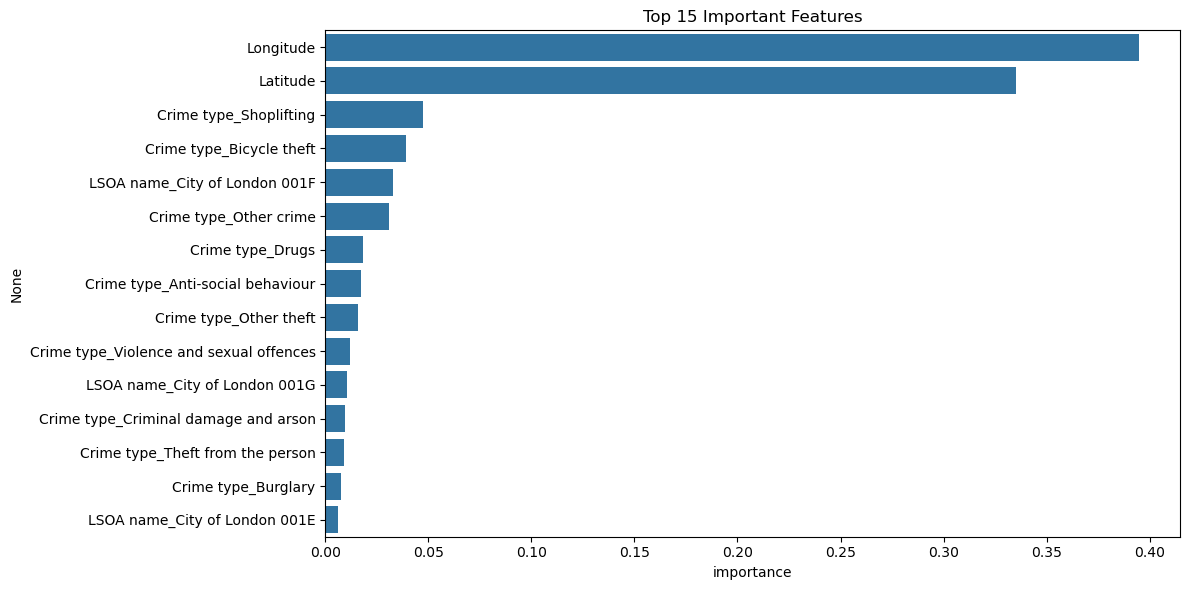

In [94]:
# Feature importance
feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index=features.columns,
    columns=['importance']).sort_values('importance', ascending=False)

# Select top 15 features
top_features = feature_importances.iloc[:15]

plt.figure(figsize=(12, 6))
sns.barplot(
    x='importance', 
    y=top_features.index,
    data=top_features  
)
plt.title('Top 15 Important Features')
plt.tight_layout()  
plt.show()

In [96]:
# Create a base map
london_coords = [51.5074, -0.1278]
risk_map = folium.Map(location=london_coords, zoom_start=12)

# Add crime locations with risk level
for idx, row in df.iterrows():
    color = 'red' if row['high_risk'] else 'blue'
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"Crime: {row['Crime type']}<br>Outcome: {row['Last outcome category']}"
    ).add_to(risk_map)

# Add cluster heatmap for high-risk areas
from folium.plugins import HeatMap

high_risk_df = df[df['high_risk'] == 1]
heat_data = [[row['Latitude'], row['Longitude']] for index, row in high_risk_df.iterrows()]
HeatMap(heat_data, radius=15).add_to(risk_map)

# Save the map
risk_map.save('crime_risk_map.html')
print("\nMap saved as 'crime_risk_map.html'")


Map saved as 'crime_risk_map.html'


 PREDICTION FOR NEW AREA

In [111]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

def geocode_address(address):
    """Convert address to latitude/longitude using Nominatim"""
    geolocator = Nominatim(user_agent="crime_risk_predictor")
    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            raise ValueError("Address not found. Try a more specific location.")
    except (GeocoderTimedOut, GeocoderUnavailable):
        raise ConnectionError("Geocoding service unavailable. Try again later.")

def predict_risk_level(address, crime_type):
    """Predict risk level for a given address"""
    # Step 1: Geocode the address to get (latitude, longitude)
    try:
        latitude, longitude = geocode_address(address)
    except Exception as e:
        return {"error": str(e)}
    
    # Step 2: Create feature vector
    features = pd.DataFrame({
        'Longitude': [longitude],
        'Latitude': [latitude],
        'Crime type': [crime_type]
    })
    
    # Step 3: One-hot encode
    features = pd.get_dummies(features)
    
    # Ensure all training columns are present
    for col in X_train.columns:
        if col not in features.columns:
            features[col] = 0
    
    # Reorder columns to match training data
    features = features[X_train.columns]
    
    # Step 4: Predict
    proba = rf.predict_proba(features)[0]
    prediction = rf.predict(features)[0]
    
    return {
        'address': address,
        'latitude': latitude,
        'longitude': longitude,
        'crime_type': crime_type,
        'high_risk_probability': float(proba[1]),  # Convert numpy.float to Python float
        'risk_level': 'High' if prediction == 1 else 'Low'
    }

In [113]:
# Example prediction
sample_prediction = predict_risk_level(
    address="Stone Buildings, London",  # User enters an address instead of coordinates
    crime_type="Theft from the person"
)

print("\nSample Prediction:")
print(sample_prediction)


Sample Prediction:
{'address': 'Stone Buildings, London', 'latitude': 51.51734755, 'longitude': -0.11377835, 'crime_type': 'Theft from the person', 'high_risk_probability': 0.08, 'risk_level': 'Low'}


In [119]:
import joblib

# Save your trained model
joblib.dump(rf, 'crime/myapp/ml/model.pkl')

# Save your training data columns for reference
joblib.dump(X_train.columns, 'crime/myapp/ml/preprocessor.pkl')

['crime/myapp/ml/preprocessor.pkl']